In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import joblib

In [8]:
df = pd.read_csv('/content/archive (1).zip')
df.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


In [9]:
df.shape

(1000, 8)

In [10]:
df.isna().sum()

gender                         0
race/ethnicity                 0
parental level of education    0
lunch                          0
test preparation course        0
math score                     0
reading score                  0
writing score                  0
dtype: int64

In [11]:
scores = df.columns[df.columns.str.contains('score')].tolist()
scores

['math score', 'reading score', 'writing score']

EDA:

histograms:

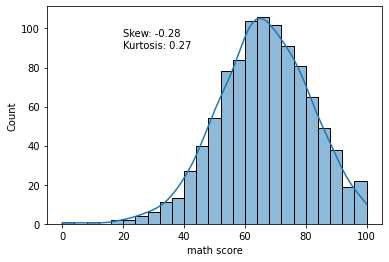

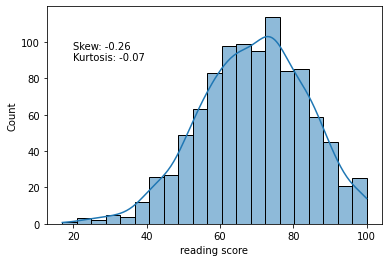

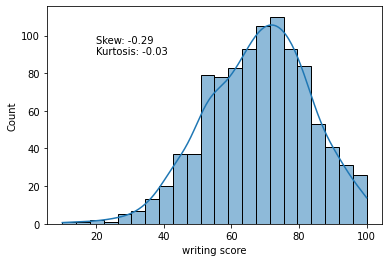

In [12]:
for score in scores:
    sns.histplot(df[score], element='bars', kde=True)
    plt.text(x=20, y=90, s=f"Skew: {round(df[score].skew(),2)}\nKurtosis: {round(df[score].kurt(),2)}")
    plt.show()

In [13]:
df.describe()

,math score,reading score,writing score
count,1000.00000,1000.000000,1000.000000
mean,66.08900,69.169000,68.054000
std,15.16308,14.600192,15.195657
min,0.00000,17.000000,10.000000
25%,57.00000,59.000000,57.750000
50%,66.00000,70.000000,69.000000
75%,77.00000,79.000000,79.000000
max,100.00000,100.000000,100.000000


pariplot:

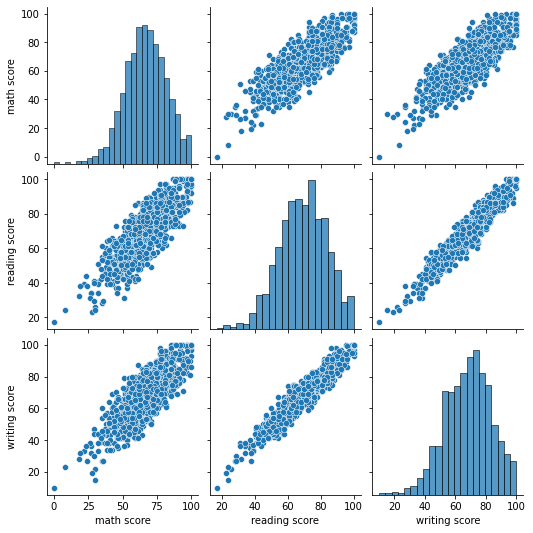

In [14]:
sns.pairplot(data=df)

scores vs lunch type:

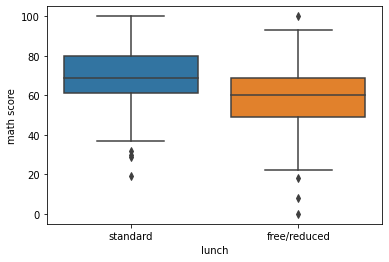

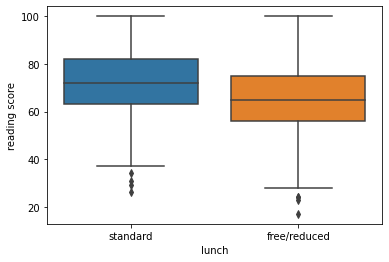

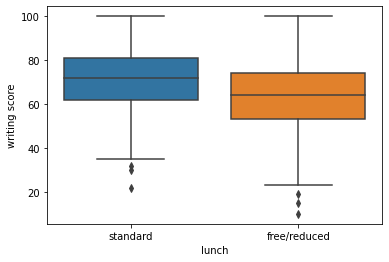

In [15]:
for score in scores:
    sns.boxplot(y=df[score], x=df['lunch'])
    plt.show()

scores vs race/ ethnicity group:

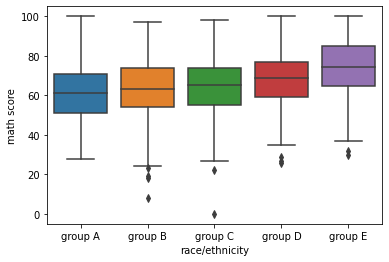

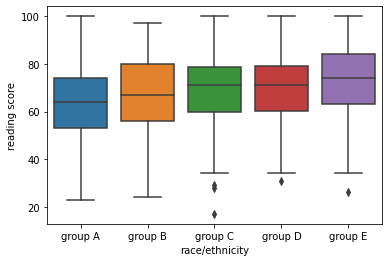

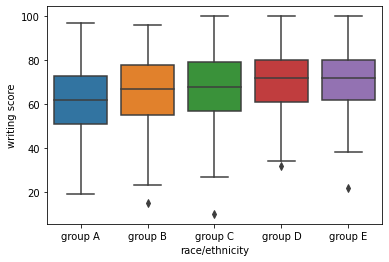

In [17]:
for score in scores:
    sns.boxplot(y=df[score], x=df['race/ethnicity'], order=sorted(df['race/ethnicity'].unique()))
    plt.show()

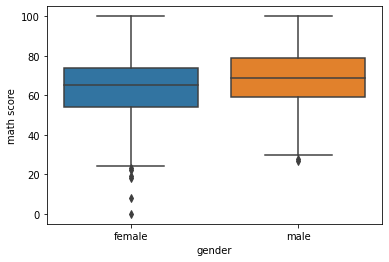

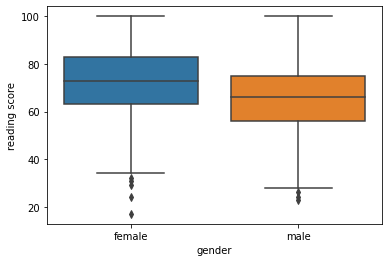

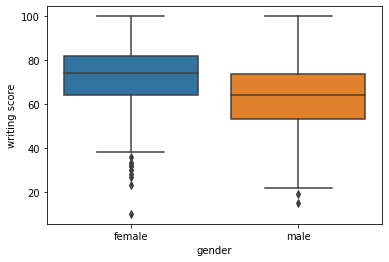

In [18]:
for score in scores:
    sns.boxplot(y=df[score], x=df['gender'])
    plt.show()

scores vs whether completed the test prep course:

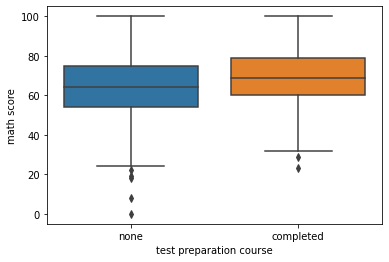

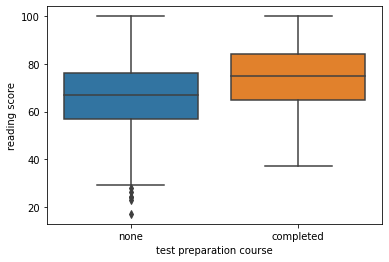

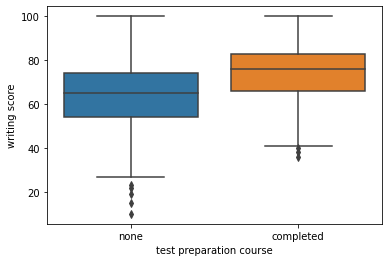

In [19]:
for score in scores:
    sns.boxplot(y=df[score], x=df['test preparation course'])
    plt.show()

scores vs parental education level:

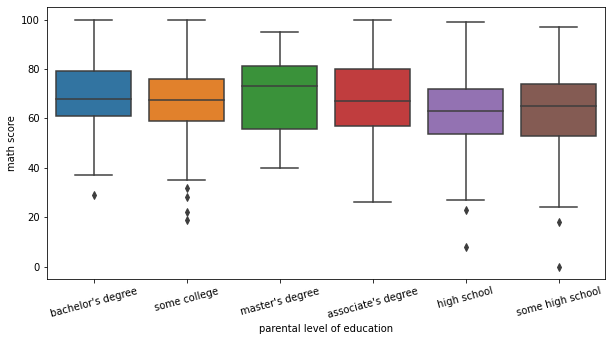

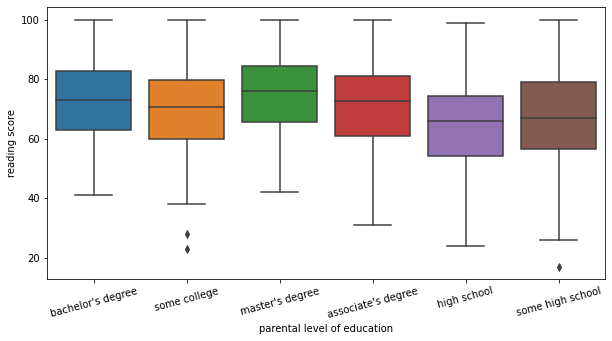

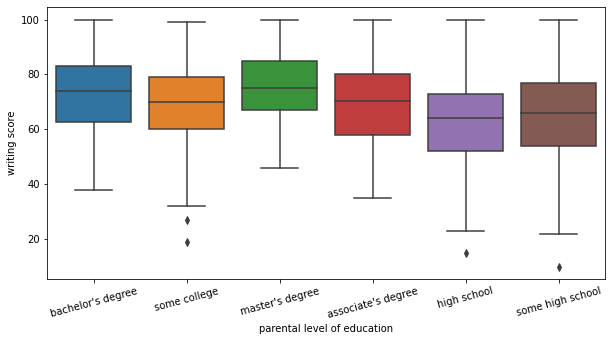

In [20]:
for score in scores:
    plt.figure(figsize=(10,5))
    sns.boxplot(y=df[score], x=df['parental level of education'])
    plt.xticks(rotation=15)
    plt.show()

In [21]:
X, y = df.drop('writing score', axis=1), df['writing score']

In [22]:
cat_cols = X.dtypes[X.dtypes == 'O'].index.tolist()
cat_cols

['gender',
 'race/ethnicity',
 'parental level of education',
 'lunch',
 'test preparation course']

In [23]:
ct = ColumnTransformer([
#     ('num', StandardScaler(), ['reading score', 'math score']),
    ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'), cat_cols)
], remainder='passthrough')

In [24]:
ct.fit_transform(X).shape

(1000, 19)

In [25]:
pipe = Pipeline([
    ('trf', ct),
    ('model', LGBMRegressor(random_state=0))
])

In [26]:
params = {
    'model__n_estimators':[100,130,150,170,190],
    'model__boosting_type': ['dart', 'gbdt', 'goss']
}

In [27]:
gs = GridSearchCV(pipe, param_grid=params, scoring='neg_root_mean_squared_error', n_jobs=-1)

In [28]:
gs.fit(X, y)

GridSearchCV(estimator=Pipeline(steps=[('trf',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse=False),
                                                                         ['gender',
                                                                          'race/ethnicity',
                                                                          'parental '
                                                                          'level '
                                                                          'of '
                                                                          'education',
                                                                

In [29]:
pd.DataFrame(gs.cv_results_).sort_values(by='rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__boosting_type,param_model__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
5,0.080462,0.009295,0.008074,0.000192,gbdt,100,"{'model__boosting_type': 'gbdt', 'model__n_est...",-4.394029,-3.919853,-3.790584,-3.823524,-4.038057,-3.993209,0.218128,1
6,0.097232,0.004538,0.008948,0.000453,gbdt,130,"{'model__boosting_type': 'gbdt', 'model__n_est...",-4.425160,-3.945710,-3.813887,-3.904709,-4.083423,-4.034578,0.213733,2
7,0.107189,0.003380,0.010279,0.001920,gbdt,150,"{'model__boosting_type': 'gbdt', 'model__n_est...",-4.446083,-3.938389,-3.830534,-3.920707,-4.117453,-4.050633,0.218526,3
8,0.124185,0.005288,0.010690,0.001982,gbdt,170,"{'model__boosting_type': 'gbdt', 'model__n_est...",-4.469208,-3.949160,-3.860081,-3.933425,-4.150942,-4.072563,0.220548,4
9,0.132959,0.003936,0.010685,0.000701,gbdt,190,"{'model__boosting_type': 'gbdt', 'model__n_est...",-4.520730,-3.977621,-3.891544,-3.949715,-4.160099,-4.099942,0.228754,5
11,0.056311,0.004278,0.008145,0.000564,goss,130,"{'model__boosting_type': 'goss', 'model__n_est...",-4.656370,-5.450082,-4.312217,-3.879143,-5.276758,-4.714914,0.586557,6
14,0.065846,0.011335,0.007858,0.001140,goss,190,"{'model__boosting_type': 'goss', 'model__n_est...",-4.672582,-5.326299,-4.311915,-4.079921,-5.460661,-4.770275,0.544430,7
13,0.065103,0.004559,0.008052,0.000301,goss,170,"{'model__boosting_type': 'goss', 'model__n_est...",-4.854100,-5.340081,-4.433902,-3.949151,-5.808151,-4.877077,0.654102,8
4,0.299824,0.007344,0.009304,0.000641,dart,190,"{'model__boosting_type': 'dart', 'model__n_est...",-5.197361,-5.100846,-5.104413,-5.218522,-5.478813,-5.219991,0.137882,9
10,0.048144,0.002866,0.008454,0.002203,goss,100,"{'model__boosting_type': 'goss', 'model__n_est...",-4.657253,-5.573131,-4.504096,-3.926161,-7.660749,-5.264278,1.309609,10


In [30]:
gs.best_params_

{'model__boosting_type': 'gbdt', 'model__n_estimators': 100}

In [31]:
gs.best_score_

-3.9932092796716128

In [32]:
gs.best_estimator_

Pipeline(steps=[('trf',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['gender', 'race/ethnicity',
                                                   'parental level of '
                                                   'education',
                                                   'lunch',
                                                   'test preparation '
                                                   'course'])])),
                ('model', LGBMRegressor(random_state=0))])

In [33]:
joblib.dump(gs.best_estimator_, 'model.joblib')

['model.joblib']

importing the model:

In [34]:
mdl = joblib.load('model.joblib')

Making predictions on a new data point NOT seen by the model

In [35]:
q = pd.DataFrame([['female', 'group A', 'high school', 'standard', 'completed', 50,87]],
             columns=X.columns)
q

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score
0,female,group A,high school,standard,completed,50,87


In [36]:
mdl.predict(q)

array([81.87659159])